# CORD-19 Visualizer

In [2]:
%matplotlib notebook

### Colab instructions

- If you are running the notebook in Google Colab, make sure to uncomment the cell bellow and run it, so that it installs the necessary packages and fetches the necessary data. 

In [3]:
# !pip install mplcursors
# !mkdir data
# !gdown https://drive.google.com/uc?id=19b_TP8CKkBPoziiO8m5sVsKSTgmAk-kZ -O data/body_volume.npy
# !gdown https://drive.google.com/uc?id=1Y4v3vePcH6fqyBpdxWHkE1kFEca4BCmO -O data/hull_faces.npy
# !gdown https://drive.google.com/uc?id=1jnWJ4hF0T-aMYXpLuBe6e-QcdvnFEAo1 -O data/mapped_articles.json

## Importing the necessary packages

In [14]:
import os
import json
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backend_bases import MouseButton
from matplotlib.widgets import Button
from mpl_toolkits.mplot3d import proj3d, Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import ipywidgets as widgets
import mplcursors
import webbrowser
import natsort
import tifffile

## LOAD BODY VOLUME

In [15]:
def get_images(images_dir, extension='.tif'):
    """Return file names of image files inside a folder.

    Args:
        folder: str - path to folder
        extension: str - acceptable extension of files
    """
    return natsort.natsorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if
                              os.path.isfile(os.path.join(images_dir, f)) and
                              f.endswith(extension)])


def read_images(images_dir, extension='.tif'):
    """Return a 3D numpy array of stacked images in folder

        Args:
            folder: str - path to folder
            extension: str - acceptable extension of files
        """
    image_files = get_images(images_dir, extension)
    images = tifffile.imread(image_files)
    return images


if os.path.exists("data/rgb"):
    volume = read_images("data/rgb")
else:
    volume = np.load("data/body_volume_mock.npy")
hull_faces = np.load("data/hull_faces.npy")
dimensions = list(volume.shape[:3])

## LOAD ARTICLE DATA

In [17]:
use_sentence_weights = False # Whether to use the sentence weighting based on sentence specificness

dframe_data = pd.read_json("data/mapped_articles.json")
sentence_mappings = dframe_data.sentence_mappings.values
sentence_weights = dframe_data.sentence_weights.values
sentence_mappings = np.array([np.array(item) for item in sentence_mappings])
sentence_weights = np.array([np.array(item) for item in sentence_weights])
if use_sentence_weights:
    data = np.array([(item1 * item2[:,None]).sum(axis=0) for item1, item2 in zip(sentence_mappings, sentence_weights)])
else:
    data = np.array([item.mean(axis=0) for item in sentence_mappings])
data = np.concatenate((data[:, 2][:, None], data[:, 0][:, None], data[:, 1][:, None]), axis=1)
data = np.clip(data, np.array([0.0, 0.0, 0.0]), np.array(dimensions) - 1.0)

## Interactive plots

<IPython.core.display.Javascript object>


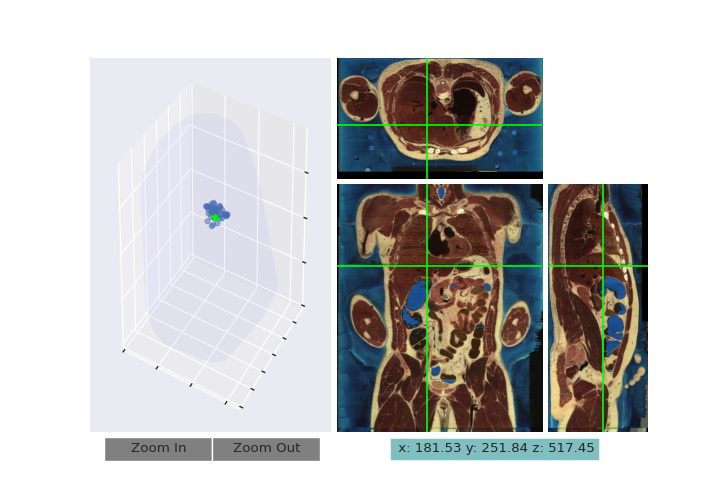

GridBox(children=(HTML(value='', description='Title:', layout=Layout(grid_area='title_box', width='auto')), HT…

In [18]:
def create_crosshair(point, tiny=False):
    global ax1
    
    if tiny:
        plus = 2
        minus = 1
        full = 3
    else:
        plus = 13
        minus = 12
        full = 25
    
    ax1.plot(point[0] * np.ones(full), 
             point[1] * np.ones(full), 
             np.arange(point[2]-minus, point[2]+plus),
             c='lime',
             linewidth=2,
             picker=False)
    ax1.plot(point[0] * np.ones(full),
             np.arange(point[1]-minus, point[1]+plus),
             point[2] * np.ones(full),
             c='lime',
             linewidth=2,
             picker=False)
    ax1.plot(np.arange(point[0]-minus, point[0]+plus),
             point[1] * np.ones(full),
             point[2] * np.ones(full), 
             c='lime',
             linewidth=2,
             picker=False)



def update_crosshair(point, tiny=False):
    global ax1
    
    if tiny:
        plus = 2
        minus = 1
        full = 3
    else:
        plus = 13
        minus = 12
        full = 25
    
    ax1.lines[0].set_data(point[0] * np.ones(full), point[1] * np.ones(full))
    ax1.lines[0].set_3d_properties(np.arange(point[2]-minus, point[2]+plus))
    
    ax1.lines[1].set_data(point[0] * np.ones(full), np.arange(point[1]-minus, point[1]+plus))
    ax1.lines[1].set_3d_properties(point[2] * np.ones(full))
    
    ax1.lines[2].set_data(np.arange(point[0]-minus, point[0]+plus), point[1] * np.ones(full))
    ax1.lines[2].set_3d_properties(point[2] * np.ones(full))
    
    
def return_closest_data_indices(point, top_K):
    distances = np.linalg.norm(np.array(point) - np.array(data), ord=2, axis=1)
    return np.argpartition(distances, top_K)[:top_K]


def open_article_url(b):
    if url_box.value:
        webbrowser.open_new(url_box.value)


def zoom_in_onto_points(b):
    global zoomed
    global ax1
    
    zoomed = True
    ax1.cla()
    sc = ax1.scatter(display_data[:, 1], 
                     display_data[:, 2], 
                     display_data[:, 0], 
                     picker=True, 
                     alpha=0.5)
    create_crosshair([point[1], point[2], point[0]], tiny=True)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    
    
def zoom_out_onto_body(b):
    global zoomed
    global ax1
    
    zoomed = False
    ax1.cla()
    sc = ax1.scatter(display_data[:, 1], 
                     display_data[:, 2], 
                     display_data[:, 0], 
                     picker=True, 
                     alpha=0.5)
    ax1.add_collection3d(Poly3DCollection(hull_faces, alpha=0.02, color='blue', edgecolor='white'))
    create_crosshair([point[1], point[2], point[0]], tiny=False)
    ax1.set_xlim((0, volume.shape[1]))
    ax1.set_ylim((0, volume.shape[2]))
    ax1.set_zlim((0, volume.shape[0]))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([]) 


def onclick(event):
    global point
    global zoomed
    global display_data
    
    if event.button != MouseButton.LEFT:
        return
    
    if event.inaxes == ax2:   
        
        point[0] = volume.shape[0] - event.ydata
        point[2] = event.xdata
        
        horiz2.set_ydata(event.ydata)
        vert2.set_xdata(event.xdata)
        
        horiz3.set_ydata(event.ydata)
        ax3.index = int(event.xdata)
        ax3.images[0].set_array(volume[:, :, ax3.index])
        
        vert4.set_xdata(event.xdata)
        ax4.index = int(event.ydata)
        ax4.images[0].set_array(volume[ax4.index, :, :])
        
    elif event.inaxes == ax3:
        
        point[0] = volume.shape[0] - event.ydata
        point[1] = event.xdata
        
        horiz3.set_ydata(event.ydata)
        vert3.set_xdata(event.xdata)
        
        horiz2.set_ydata(event.ydata)
        ax2.index = int(event.xdata)
        ax2.images[0].set_array(volume[:, ax2.index, :])
        
        horiz4.set_ydata(event.xdata)
        ax4.index = int(event.ydata)
        ax4.images[0].set_array(volume[ax4.index, :, :])
        
    elif event.inaxes == ax4:
        
        point[1] = event.ydata
        point[2] = event.xdata
        
        horiz4.set_ydata(event.ydata)
        vert4.set_xdata(event.xdata)
        
        vert2.set_xdata(event.xdata)
        ax2.index = int(event.ydata)
        ax2.images[0].set_array(volume[:, ax2.index, :])
        
        vert3.set_xdata(event.ydata)
        ax3.index = int(event.xdata)
        ax3.images[0].set_array(volume[:, :, ax3.index])
        
    else:
        return
    
    zoomed = False
    
    ax_point.cla()
    ax_point.text(0.15, 0.35, f" x: {point[1]:.2f} y: {point[2]:.2f} z: {point[0]:.2f}", 
             bbox=dict(facecolor='teal', alpha=0.5))
    ax_point.axis('off')
    
    ind = np.argmin(np.square(np.array(point) - data).sum(axis=1))
    closest_indices = return_closest_data_indices(np.array(point), top_K = top_K)
    display_data = data[closest_indices, :]
    
    ax1.cla()
    sc = ax1.scatter(display_data[:, 1], 
                     display_data[:, 2], 
                     display_data[:, 0], 
                     picker=True, 
                     alpha=0.5)
    ax1.add_collection3d(Poly3DCollection(hull_faces, alpha=0.02, color='blue', edgecolor='white'))
    create_crosshair([point[1], point[2], point[0]], tiny=zoomed)
    ax1.set_xlim((0, volume.shape[1]))
    ax1.set_ylim((0, volume.shape[2]))
    ax1.set_zlim((0, volume.shape[0]))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])

    
    title_box.value = dframe_data.iloc[ind]['title']
    author_box.value = dframe_data.iloc[ind]['authors']
    abstract_box.value = dframe_data.iloc[ind]['abstract']
    author_box.value = dframe_data.iloc[ind]['authors']
    doi_box.value = dframe_data.iloc[ind]['doi']
    url_box.value = dframe_data.iloc[ind]['url']
    publication_time = dframe_data.iloc[ind]['publish_time']
    year_box.value = datetime.datetime.fromtimestamp(publication_time / 1e3).strftime("%d/%m/%Y")
    
    
def onpick(event):
    global point
    global zoomed
    global display_data
    
    ind = event.ind[0]
    point = display_data[ind]

    ax2.index = int(point[1])
    ax2.images[0].set_array(volume[:, ax2.index, :])
    horiz2.set_ydata(volume.shape[0] - point[0])
    vert2.set_xdata(point[2])

    ax3.index = int(point[2])
    ax3.images[0].set_array(volume[:, :, ax3.index])
    horiz3.set_ydata(volume.shape[0] - point[0])
    vert3.set_xdata(point[1])

    ax4.index = int(volume.shape[0] - point[0])
    ax4.index = max(0, min(ax4.index, volume.shape[0] - 1))
    ax4.images[0].set_array(volume[ax4.index, :, :])
    horiz4.set_ydata(point[1])
    vert4.set_xdata(point[2])
    
    ax_point.cla()
    ax_point.text(0.15, 0.35, f" x: {point[1]:.2f} y: {point[2]:.2f} z: {point[0]:.2f}", 
             bbox=dict(facecolor='teal', alpha=0.5))
    ax_point.axis('off')
    
    update_crosshair([point[1], point[2], point[0]], tiny=zoomed)
    
    kita = ind
    
    title_box.value = dframe_data.iloc[ind]['title']
    author_box.value = dframe_data.iloc[ind]['authors']
    abstract_box.value = dframe_data.iloc[ind]['abstract']
    author_box.value = dframe_data.iloc[ind]['authors']
    doi_box.value = dframe_data.iloc[ind]['doi']
    url_box.value = dframe_data.iloc[ind]['url']
    publication_time = dframe_data.iloc[ind]['publish_time']
    year_box.value = datetime.datetime.fromtimestamp(publication_time / 1e3).strftime("%d/%m/%Y")
    
    
top_K = 50
zoomed = False
url = None
point = [volume.shape[0] // 2, volume.shape[1] // 2, volume.shape[2] // 2]
display_data = data[return_closest_data_indices(np.array(point), top_K = top_K)]

title_box = widgets.HTML(
    value="",
    description="Title:",
    layout=widgets.Layout(width='auto', grid_area='title_box')
)

author_box = widgets.HTML(
    value="",
    description="Authors:",
    layout=widgets.Layout(width='auto', grid_area='author_box')
)

year_box = widgets.HTML(
    value="",
    description="Date:",
    layout=widgets.Layout(width='auto', grid_area='year_box')
)

doi_box = widgets.HTML(
    value="",
    description="DOI:",
    layout=widgets.Layout(width='auto', grid_area='doi_box')
)

url_box = widgets.HTML(
    value="",
    description="URL:",
    layout=widgets.Layout(width='auto', grid_area='url_box')
)

abstract_box = widgets.HTML(
    value="",
    description="Abstract:",
    layout=widgets.Layout(width='auto', grid_area='abstract_box')
)

url_button = widgets.Button(
    description="Open URL", 
    tooltip="Open URL",
    button_style='success',
    layout=widgets.Layout(width='auto', grid_area='url_button')
)
    
url_button.on_click(open_article_url)
    
sns.set()

fig = plt.figure(figsize = (9, 6))
plt.subplots_adjust(bottom=0.1)
grid = plt.GridSpec(12, 16, hspace=0.2, wspace=0.2)

ax1 = fig.add_subplot(grid[:, :7], projection='3d')
sc = ax1.scatter(display_data[:, 1], display_data[:, 2], display_data[:, 0], picker=True, alpha=0.5)
ax1.add_collection3d(Poly3DCollection(hull_faces, alpha=0.02, color='blue', edgecolor='white'))
create_crosshair([volume.shape[1] // 2, volume.shape[2] // 2, volume.shape[0] // 2], tiny=zoomed)
ax1.set_xlim((0, volume.shape[1]))
ax1.set_ylim((0, volume.shape[2]))
ax1.set_zlim((0, volume.shape[0]))
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
cursor = mplcursors.cursor(ax1, highlight=False)   
@cursor.connect("add")
def _(sel):
    sel.annotation.set(text="", bbox=None)
    sel.annotation.arrow_patch.set(alpha=0.0)


# x, z, y
ax2 = fig.add_subplot(grid[4:, 7:13])
ax2.index = volume.shape[1] // 2
ax2.imshow(volume[:, ax2.index, :], aspect="auto")
horiz2 = ax2.axhline(volume.shape[0] // 2, color='lime')
vert2 = ax2.axvline(volume.shape[2] // 2, color='lime')
ax2.axis('off')

# y, z, x
ax3 = fig.add_subplot(grid[4:, 13:])
ax3.index = volume.shape[2] // 2
ax3.imshow(volume[:, :, ax3.index], aspect="auto")
horiz3 = ax3.axhline(volume.shape[0] // 2, color='lime')
vert3 = ax3.axvline(volume.shape[1] // 2, color='lime')
ax3.axis('off')

ax4 = fig.add_subplot(grid[:4, 7:13])
ax4.index = volume.shape[0] // 2
ax4.imshow(volume[ax4.index, :, :], aspect="auto")
horiz4 = ax4.axhline(volume.shape[1] // 2, color='lime')
vert4 = ax4.axvline(volume.shape[2] // 2, color='lime')
ax4.axis('off')

fig.canvas.mpl_connect('pick_event', onpick)
fig.canvas.mpl_connect('button_press_event', onclick)

    
widget_box = widgets.GridBox(
    children=[title_box, author_box, year_box, url_box, url_button, doi_box, abstract_box],
    layout=widgets.Layout(
        width='100%',
#         grid_template_rows='10% 10% 10% 10% 10% 50%',
        grid_template_rows='auto auto auto auto auto auto',
        grid_template_columns='50% 10% 20% 10%',
        grid_template_areas=
        '''
        "title_box title_box title_box title_box"
        "author_box author_box author_box author_box"
        "year_box year_box year_box year_box"
        "url_box . url_button ."
        "doi_box doi_box doi_box doi_box"
        "abstract_box abstract_box abstract_box abstract_box"
        '''
    )
)

ax_zoom_in = plt.axes([0.145, 0.04, 0.15, 0.05])
button_zoom = Button(ax_zoom_in, 'Zoom In', color='gray', hovercolor='teal')
button_zoom.on_clicked(zoom_in_onto_points)

ax_zoom_out = plt.axes([0.295, 0.04, 0.15, 0.05])
button_unzoom = Button(ax_zoom_out, 'Zoom Out', color='gray', hovercolor='teal')
button_unzoom.on_clicked(zoom_out_onto_body)

ax_point = plt.axes([0.525, 0.04, 0.15, 0.05])
ax_point.text(0.15, 0.35, f" x: {point[1]:.2f} y: {point[2]:.2f} z: {point[0]:.2f}",
         bbox=dict(facecolor='teal', alpha=0.5))
ax_point.axis('off')


widget_box